In [22]:
#@title Imports { vertical-output: true, form-width: "15%" }
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import os.path
import matplotlib.style as style 
from google.colab import drive
drive.mount('/content/drive')
sns.set(style="darkgrid")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@title Parameter Settings { vertical-output: true, form-width: "15%" }

#reading in parameter settings and creating dict for data viz
os.chdir('/content/drive/MyDrive/KAUST!!/researchProj/hydrogenProduction/outputAnalysis')

pdSingleParamDataset = pd.read_excel(f"../dataInputs/inputSheet.xlsx",sheet_name='systemSettings')
pdEyParamDataset = pd.read_excel("../dataInputs/inputSheet.xlsx",sheet_name='eyUnitSettings')
#cfWind = pd.read_excel("../dataInputs/reData.xlsx",sheet_name='cfWind')
#cfSolar = pd.read_excel("../dataInputs/reData.xlsx",sheet_name='cfSolar')


parameterSettingsDict = {}

for paramName,paramValue in zip(pdSingleParamDataset["ParamName"],pdSingleParamDataset["Value"]):
    parameterSettingsDict[paramName] = paramValue

plt.rcParams["font.family"] = "serif"

In [19]:
#@title Read in multiple time periods and sites data { form-width: "15%" }

totalTimePeriods = ["2017","2018","2019"]
sites = ["northWest","centralWest","northEast"]

#master dataset (holds all data from different times with cost breakdown)
masterDataset = {}

for site in sites:
  windCost = []
  solarCost = []
  eyCost = []
  for timePeriod in totalTimePeriods:
    #reading in output from optimization model and setting up structure for data viz
    #excelName = f"northWestSite_{timePeriod[0]}_{timePeriod[1]}"
    excelName = f"{site}_base_{timePeriod}"

    #getting out year results for site
    singleValueData = pd.read_excel(f"../modelOutputs/baseResults/{excelName}.xlsx",sheet_name="singleValueDvs").abs()

    #adding to respective list
    windCost.append(singleValueData["windCosts"][0])
    solarCost.append(singleValueData["solarCosts"][0])
    eyCost.append(singleValueData["eyCosts"][0])

  masterDataset[site,"solar"] = np.array(solarCost)
  masterDataset[site,"wind"] = np.array(windCost)
  masterDataset[site,"ey"] = np.array(eyCost)


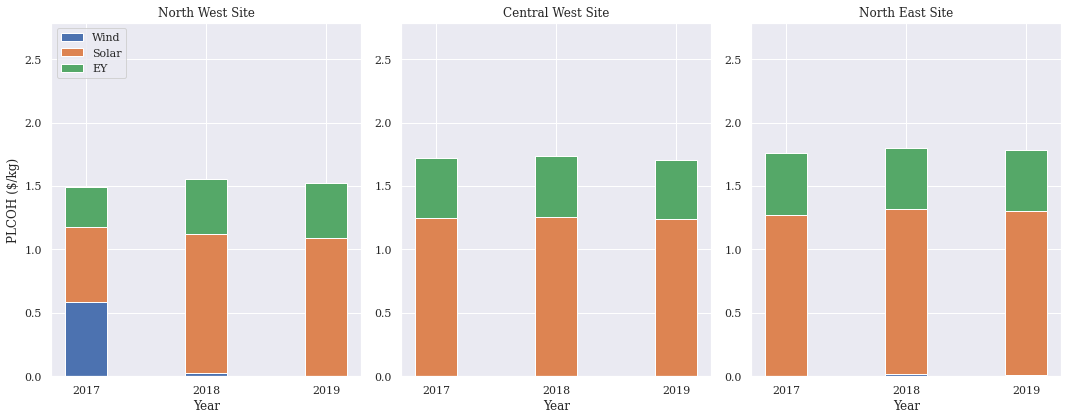

In [23]:
#@title Main Paper Figure 1 { form-width: "15%" }
plt.rcParams["font.family"] = "serif"


costDataColNames = ["wind","solar","ey"]
labelList = ["Wind","Solar","EY"]
titleList = ["North West Site", "Central West Site", "North East Site"]

labels = totalTimePeriods
width = 0.35 

#getting max totalCost for each site and year (need to sum up cost components)
maxCost = 0
for site in sites:
  for year in [0,1,2]:
    totalCost = 0
    for costComponent in costDataColNames:
      totalCost += masterDataset[site,costComponent][year]

    #checking to see if cost is greater than max
    if(totalCost > maxCost):
      maxCost = totalCost   


maxCost = totalCost + 1



fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

for siteCount,site in enumerate(sites):
  barBottomNum = 0.0
  for costColCount,costDataCol in enumerate(costDataColNames): 
    ax[siteCount].bar(labels, masterDataset[site,costDataCol], width, bottom=barBottomNum,  label=labelList[costColCount])

    #adding bottom of bar
    barBottomNum += masterDataset[site,costDataCol]
  
  #adding graph information
  if(siteCount == 0):
    ax[siteCount].set_ylabel('PLCOH ($/kg)')
    ax[siteCount].set_xlabel('Year')
    ax[siteCount].set_title(titleList[siteCount])
    ax[siteCount].set_ylim(top=maxCost)
    ax[siteCount].legend(loc="upper left")
  else:
    ax[siteCount].set_xlabel('Year')
    ax[siteCount].set_title(titleList[siteCount])
    ax[siteCount].set_ylim(top=maxCost)

plt.tight_layout()
plt.show()

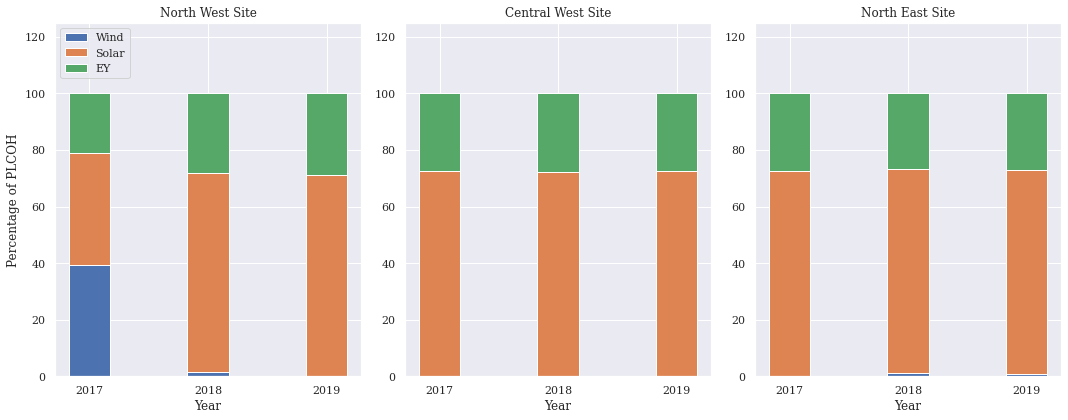

In [24]:
#@title Main Paper Figure 2: Percentage { form-width: "15%" }
plt.rcParams["font.family"] = "serif"


costDataColNames = ["wind","solar","ey"]
labelList = ["Wind","Solar","EY"]
titleList = ["North West Site", "Central West Site", "North East Site"]

labels = totalTimePeriods
width = 0.35 
maxCost = 125


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

for siteCount,site in enumerate(sites):
  barBottomNum = 0.0

  #getting total cost first for percentages
  totalCost = 0.0
  for costColCount,costDataCol in enumerate(costDataColNames): 
    totalCost += masterDataset[site,costDataCol]

  for costColCount,costDataCol in enumerate(costDataColNames): 
    ax[siteCount].bar(labels, 100.0*masterDataset[site,costDataCol]/totalCost, width, bottom=barBottomNum,  label=labelList[costColCount])

    #adding bottom of bar
    barBottomNum += 100.0*masterDataset[site,costDataCol]/totalCost
  
  #adding graph information
  if(siteCount == 0):
    ax[siteCount].set_ylabel('Percentage of PLCOH')
    ax[siteCount].set_xlabel('Year')
    ax[siteCount].set_title(titleList[siteCount])
    ax[siteCount].set_ylim(top=maxCost)
    ax[siteCount].legend(loc="upper left")
  else:
    ax[siteCount].set_xlabel('Year')
    ax[siteCount].set_title(titleList[siteCount])
    ax[siteCount].set_ylim(top=maxCost)

plt.tight_layout()
plt.show()

In [14]:
#@title Main Paper Sensitivity Tests Data Load { form-width: "15%" }

siteLocation = "northWestSite"

#setting up correct filenames list and parameter values tested
fileNameList = []
startValue = .5
step = .1
stopValue = 1.6


#master dataset (holds all data from different times)
masterDataset = {}
for key in ["capexSolar","capexWind","capexEY","WACC"]:
    masterDataset[key] = []

for key in ["capexSolar","capexWind","capexEY","WACC"]:
  fileNameList = []
  for value in np.arange(startValue,stopValue,step):
    fileNameList.append(f"{siteLocation}_{key}_{np.round(value,decimals=1)}")
  for fileName in fileNameList:
    #reading in output from optimization model and setting up structure for data viz
    singleValueData = pd.read_excel(f"../modelOutputs/{key}/{fileName}.xlsx",sheet_name="singleValueDvs").abs()
    masterDataset[key].append(singleValueData["LCOH"][0])


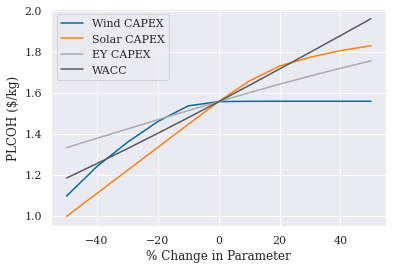

In [17]:
#@title Main Paper Sensitivity Tests Plot { form-width: "15%" }

style.use('tableau-colorblind10')
plt.rcParams["font.family"] = "serif"

fig,ax = plt.subplots()

tickMarks = 100*np.arange(startValue-1,stopValue-1,step)

plt.plot(tickMarks,masterDataset["capexWind"],label="Wind CAPEX")
plt.plot(tickMarks,masterDataset["capexSolar"],label="Solar CAPEX")
#plt.plot(tickMarks,masterDataset["capexBSpower"],label="BS")
plt.plot(tickMarks,masterDataset["capexEY"],label="EY CAPEX")
plt.plot(tickMarks,masterDataset["WACC"],label="WACC")

plt.legend()
_ = plt.ylabel("PLCOH ($/kg)")
_ = plt.xlabel("% Change in Parameter")
plt.show()